## used this to obtain 77% accuracy score using about 50 epochs. but since then i've done so much twiddling that the model is unrecognizably different. 

started working on learning to use keras for encoding

experimented with both droppign minority class and also balancing the classes by adding a weight 



In [25]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Process for sequential lstm on text classification 
1. clean entire corpus, removing stopwords html, and anything else specific to the DS
2. split cleaned data into test / train (val)
3. tokenize X, fit the transformers on train only then transform test and val
4. encode/tokenize y, (class labels) for training * also transform to binary (onehot) MATRIX *
5. fit and evaluate model
6. use transformers in pipeline to allow predict to consume 'raw input' 



In [22]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 38.0 gigabytes of available RAM

You are using a high-RAM runtime!


In [23]:

import csv
import re
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
from bs4 import BeautifulSoup
from sklearn.preprocessing import FunctionTransformer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

from numpy import argmax
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2.3.0


In [24]:
def clean_text(X):
    """
        customized cleaning function
        X: series
    
        return: np.array
    """
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    number = re.compile('[0-9]+\s')  #remove freestanding numbers

    X = X.map(lambda t : t.lower()) # lwercase text
    X = X.map(lambda t : re.sub("\\n", ' ', t))
    X = X.map(lambda t : re.sub("\\\\x..", '',t))   
    X = X.map(lambda t : re.sub("^b[\'\"]", '',t))   
    X = X.map(lambda t : BeautifulSoup(t, "lxml").text) # strip html tags
    X = X.map(lambda t : REPLACE_BY_SPACE_RE.sub(' ', t))  # symbols by space in text
    X = X.map(lambda t : BAD_SYMBOLS_RE.sub('', t)) # delete symbols which are in BAD_SYMBOLS_RE
    X = X.map(lambda t : number.sub('', t))         # remove groups of digits
    X = X.map(lambda t : ' '.join(word for word in t.split() if word not in STOPWORDS))# delete stopwords
    return np.array(X)

clean = FunctionTransformer(clean_text)

# New Section

In [48]:
#import train

df= pd.read_csv('/content/drive/My Drive/whiskeytangofoxtrot.csv')
## drop the 2s just for shiggles

cond = df['ratingCategory'] != 2
df = df[cond]

neg, pos = np.bincount(df['ratingCategory'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 4022
    Positive: 2881 (71.63% of total)



In [64]:

df.ratingCategory
clean_text(df.description)


array(['sometimes whisky batched leftover barrels returned warehouse canadian club recently pulled vatted several 1970s acetone granny smith apples freshcut white cedar showcase long age complex spicy yet reserved dram ripe strawberries canned pears cloves pepper faint flowers slightly pulling oak tannins distinct elegant remarkably vibrant ancient canadian club anything tired australia a133',
       'uncommon exclusive bottling year old cask strength malt light gold color nose vegetal peat bog peat smoke undercurrent pastry cream rose odd combination aromas entry flavorful inviting smoked pineapple clove rose peak smoke arrives full force midpalate drops sweet becomes spicy finish mostly smoke pleasant minty coolness wyoming',
       'release port version amruts intermediate sherry sort port pipe sandwich spirit matured unused casks bourbon casks spends months port pipes returns bourbon casks result pink floyd show whisky vibrant colorful complex nearly much blackcurrant wispy smoky n

In [28]:
# train val split
training_portion = .8
train_size = int(df.shape[0] * training_portion)

train,val = df[0: train_size],df[train_size:]
  
labels = df['ratingCategory'].apply(lambda x : 1 if (x is 2) else x)  #drop the minor category
y_train = labels[0: train_size]
y_val = labels[train_size:]
type(y_train)

pandas.core.series.Series

In [29]:
y_val.value_counts(normalize=True)

1    0.722494
0    0.277506
Name: ratingCategory, dtype: float64

In [30]:
y_train.shape, y_val.shape


((3269,), (818,))

In [31]:
vocab_size = 10000
embedding_dim = 16
max_length = 300
trunc_type='post'
oov_tok = "<OOV>"

test  = pd.read_csv('/content/drive/My Drive/test.csv')  ## kaggle test X 


train_texts = clean_text(train['description']).tolist()
val_texts = clean_text(val.description).tolist()

test_texts = clean_text(test['description']).tolist()

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_texts)   #for train, 


word_index = tokenizer.word_index

X_test_seq = tokenizer.texts_to_sequences(test_texts)
X_test_padded = pad_sequences(X_test_seq,maxlen=max_length, truncating=trunc_type)

X_train_sequences = tokenizer.texts_to_sequences(train_texts)     # sequences is a list of seq
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, truncating=trunc_type)  #training X, y
X_val_seq = tokenizer.texts_to_sequences(val_texts)
X_val_padded= pad_sequences(X_val_seq, maxlen=max_length, truncating=trunc_type)



train_y = tf.keras.utils.to_categorical(y_train.tolist())    # https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
val_y =   tf.keras.utils.to_categorical(y_val.tolist() )

In [58]:
len(train_y) , len(X_train_sequences)
len(val_y), len(X_val_seq), len(X_val_padded)

(818, 818, 818)

In [62]:
model = tf.keras.Sequential([
#tf.keras.layers.Embedding(vocab_size, 13),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(2 , activation='softmax')   ## this matches the number of categories
])

model.summary()
model.compile(
             loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
NUM_EPOCHS = 10
history = model.fit(X_train_padded,train_y,  epochs=NUM_EPOCHS, 
                    validation_data=(X_val_padded, val_y) )
#model.evaluate(X_train_padded)


ValueError: ignored

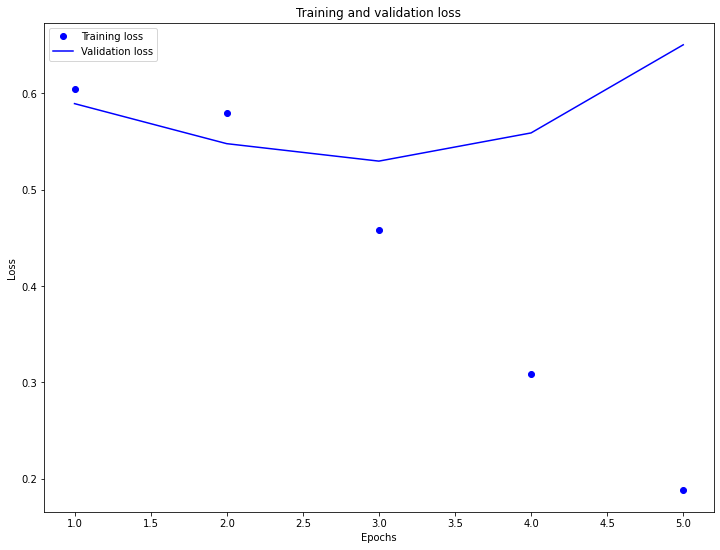

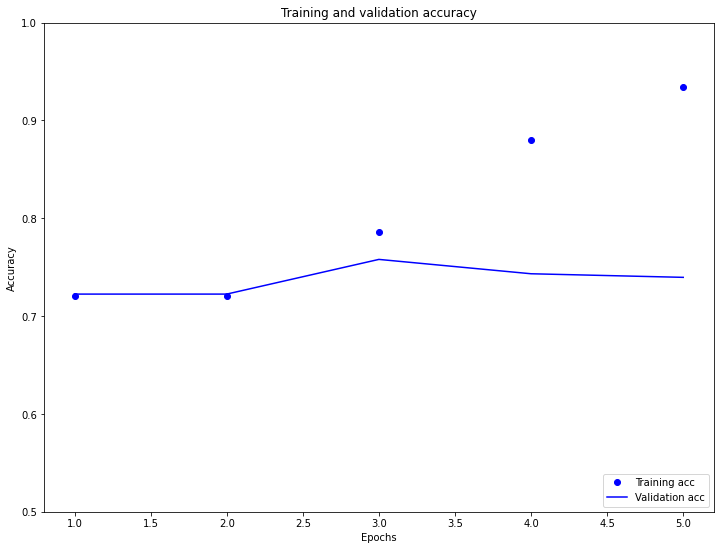

In [44]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']

val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [35]:
%cd /content/drive/My Drive
model.save(
    'whiskytango', overwrite=True, include_optimizer=True, save_format='h5',
    signatures=None, options=None
)

/content/drive/My Drive


In [36]:
X_test_padded.shape,X_train_padded.shape

((1022, 300), (3269, 300))

In [37]:
predictions = model.predict(X_test_padded)  #array 

In [38]:
preds= []
for row in predictions:
  preds.append(np.argmax(row))
subtf = pd.DataFrame(preds, index=test.id, columns=["ratingCategory"])


In [39]:
subtf.to_csv('3e2ltf.csv')

In [40]:
!pwd



/content/drive/My Drive


# New Section

In [41]:
%pwd

'/content/drive/My Drive'

Good up to here.  
TODO : 

- load model and predict 
- deploy to heroku 
- integrate preprocessing 


In [42]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')